# Set 1
## Load data

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [75]:
from IPython.display import SVG, display
from tqdm import tqdm
from pyclustertend import hopkins,ivat
from tqdm import tqdm


import hdbscan
import umap
import pickle
import os
import itertools
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from distinctipy import distinctipy

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [76]:
def get_score(X, labels):
    result = {}
    try:
        result['silhouette_score'] = silhouette_score(X, labels, metric='manhattan')
    except:
        result['silhouette_score'] = np.nan

    try:
        result['calinski_harabasz_score'] = calinski_harabasz_score(X, labels)
    except:
        result['calinski_harabasz_score'] = np.nan

    try:
        result['davies_bouldin_score'] = davies_bouldin_score(X, labels)
    except:
        result['davies_bouldin_score'] = np.nan
    return result

In [77]:
def make_countplot(df, x, hue):  
    colors = distinctipy.get_colors(len(set(df[hue])), colorblind_type='Deuteranomaly',
                                    n_attempts=10_000)
    pallette = sns.set_palette(sns.color_palette(colors))
    # Make the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
    df = df.sort_values(hue)
    g = sns.countplot(x=x, hue=hue, palette=pallette, edgecolor=".6", 
                      data=df, ax=ax1)
    g.get_legend().remove()
    g.set_title('Absoulte counts')

    counts = (df.groupby([hue])[x]
              .value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(hue))
    g1 = sns.barplot(x=x, y="percentage", hue=hue,
                     data=counts, palette=pallette, edgecolor=".6", ax=ax2)

    g1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    g1.set_title('Relative counts')
    plt.show()

In [78]:
def time_plot(x, alg):
    try:
        x = x.values
    except:
        pass
    
    spacings = [0.25 , 0.5 , 0.75, 1]
    taken_rows = np.arange(0, x.shape[0])
    col1 = []
    col2 = []
    for spacing in spacings:
        row = np.random.choice(taken_rows, size=round(spacing * len(taken_rows)), replace=False)
        x_sample = x[row]
        for i in range(5):
            start_time = time.time()
            alg.fit(x_sample)
            stop_time = time.time() - start_time
            col1.append(x_sample.shape[0])
            col2.append(stop_time)
    fig = plt.figure(figsize=(10,10))
    sns.lineplot(x=col1, y=col2)
    plt.xlabel('Row Count')
    plt.ylabel('Time (s)')
    plt.title("Time plot")
    plt.show()

In [79]:
def cluster_plot(grid):
    if 'n_clusters' in grid.columns:
        df = grid.groupby(['n_clusters']).max().reset_index()
        df = df.sort_values('n_clusters')
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,9))
        sns.lineplot(data=df, x='n_clusters', y='silhouette_score', ax=ax1, color='black')
        sns.lineplot(data=df, x='n_clusters', y='calinski_harabasz_score', ax=ax2, color='black')
        ax1.set_xlabel('Number clusters')
        ax1.set_ylabel('Silhouette score')
        ax2.set_ylabel('calinski Harabasz score')
        ax2.set_xlabel('Number clusters')
        fig.suptitle("Scores vs clusters")
        plt.show()
    else:
        df = grid.groupby(['K']).max().reset_index()
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,9))
        sns.lineplot(data=df, x='K', y='BIC', ax=ax1, color='black')
        sns.lineplot(data=df, x='K', y='ICL', ax=ax2, color='black')
        ax1.set_xlabel('Number clusters')
        ax1.set_ylabel('BIC')
        ax2.set_ylabel('ICL')
        ax2.set_xlabel('Number clusters')
        fig.suptitle("Scores vs clusters")
        plt.show()
    

In [80]:
import re

def get_score_df(df, norm_df):
    scores_df = {}
    for column in df:
        scores_df[column] = get_score(norm_df, df[column].values)
    scores_df = pd.DataFrame(scores_df).T
    scores_df.index = scores_df.index.set_names(['n_clusters'])
    scores_df = scores_df.reset_index()
    scores_df['n_clusters'] = scores_df['n_clusters'].astype('int64')
    return scores_df

def merge_Results(directory, alg, norm_df):
    grid_df = pd.DataFrame()
    cluster_df = pd.DataFrame()
    for filename in os.listdir(directory):
        if filename.endswith(".csv"): 
            if 'Grid' in filename and alg in filename:
                df = pd.read_csv(f'{directory}/{filename}', index_col=0)
                df = df.T.reset_index(drop=True)
                grid_df = grid_df.append(df, ignore_index=True)
            if 'Clusters' in filename and alg in filename:
                try:
                    cluster_df[re.findall(r'\d+', filename)[0]] = pd.read_csv(f'{directory}/{filename}', index_col=0).values.ravel()
                except:
                    pass
    scores_df = get_score_df(cluster_df, norm_df)
    
    if alg == 'HDDC':
        grid_df = grid_df.sort_values('BIC',  ascending=False)
        grid_df['rank'] = np.arange(1,len(grid_df)+1)
        grid_df = grid_df.drop('originalOrder', axis=1)
        return cluster_df, scores_df, grid_df
    else:
        return cluster_df, scores_df
    

In [81]:
gene_expression = pd.read_csv(
    "/data/g0017139/Set1/CCLE__Affy_hgu133plus2_QCed_mRNA_NoDuplicates_CleanedIdentifiers_RMA-sketch_genelevel_using_jetscore.txt",
    sep=None, engine='python', header=0,
)
gene_expression = gene_expression.T

In [82]:
gene_expression.shape

(1067, 19635)

In [83]:
gene_expression.head()

1         2         9       \
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A01_436578.CEL  4.223429  3.674479  7.277365   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A02_436580.CEL  4.384075  3.750469  6.997519   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A03_436582.CEL  6.783196  3.767826  3.897323   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A05_436586.CEL  4.476213  4.029830  9.350321   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A06_436588.CEL  5.596887  3.794230  9.037694   

                                                   10        12        13      \
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A01_436578.CEL  4.145208  4.029598  3.433433   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A02_436580.CEL  5.128134  3.978323  4.304716   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A03_436582.CEL  4.133214  4.129925  3.647417   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A05_436586.CEL  4.497987  4.521013  3.595288   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A06_436588.CEL  4.560074  3.839451  3.591908   

                                                   14        15      \
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A01_436578.CEL  8.946383  3.249680   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A02_436580.CEL  8.948517  3.416038   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A03_436582.CEL  8.780586  3.735504   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A05_436586.CEL  9.101276  3.520743   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A06_436588.CEL  9.559303  3.654630   

                                                    16        18      ...  \
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A01_436578.CEL  10.276116  8.101744  ...   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A02_436580.CEL   9.622012  5.498473  ...   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A03_436582.CEL   9.370273  3.738432  ...   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A05_436586.CEL   9.955727  5.768418  ...   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A06_436588.CEL   9.934966  5.939260  ...   

                                                   10524     10938     11054   \
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A01_436578.CEL  7.975829  7.666894  6.542198   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A02_436580.CEL  7.875326  8.847765  7.690263   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A03_436582.CEL  7.569357  7.408654  6.259688   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A05_436586.CEL  7.662641  9.527644  7.908985   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A06_436588.CEL  8.425545  9.359440  7.259569   

                                                   23061     54869   \
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A01_436578.CEL  7.748051  4.514262   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A02_436580.CEL  8.136758  6.141332   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A03_436582.CEL  6.868895  4.438964   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A05_436586.CEL  7.012102  4.701159   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A06_436588.CEL  7.445686  4.149302   

                                                    60674     79133   \
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A01_436578.CEL  12.642093  9.141612   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A02_436580.CEL  12.151447  8.009569   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A03_436582.CEL  11.698306  8.672440   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A05_436586.CEL  12.965402  9.406763   
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A06_436588.CEL  11.995794  8.860146   

                                                   147660    245972     729348  
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A01_436578.CEL  3.779939  5.276707  14.115320  
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A02_436580.CEL  3.706794  5.516570  12.147721  
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A03_436582.CEL  3.814778  5.595085  12.287252  
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A05_436586.CEL  3.838322  6.038491  11.017916  
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_A06_436588.CEL  3.816308  5.552706  10.789574  

[5 rows x 19635 columns]

In [84]:
Entrez_Map = pd.read_csv('/data/g0017139/Set1/Entrezid_mapping_using_org_Hs_eg_db_03052021.txt',
                               sep=None, engine='python', header=0,
)
Entrez_Map.sort_values(['CHR_Mapping', 'BP_Mapping'], axis=0, inplace=True)
Entrez_Map.head()

mapped_entrez_v1  CHR_Mapping  BP_startloc  BP_endloc  \
1              653635            1      14361.0    29370.0   
11              79501            1      69090.0    70008.0   
128         100132287            1     490755.0   495445.0   
150            729759            1     568227.0   569166.0   
168         101928626            1     627379.0   629009.0   

     sense_or_antisense                                           GENENAME  \
1                    -1                  WASP family homolog 7, pseudogene   
11                    1   olfactory receptor family 4 subfamily F member 5   
128                  -1                       uncharacterized LOC100132287   
150                  -1  olfactory receptor family 4 subfamily F member 29   
168                  -1                       uncharacterized LOC101928626   

           SYMBOL  BP_Mapping  
1          WASH7P     21865.5  
11          OR4F5     69549.0  
128  LOC100132287    493100.0  
150        OR4F29    568696.5  
168  LOC101928626    628194.0

In [85]:
TumorType = pd.read_csv('/data/g0017139/Set1/CCLE__Sample_To_TumorType.csv',
                               sep=None, engine='python', header=0,
                       )

TumorType = TumorType.set_index('GSM_IDENTIFIER')
TumorType.head()

TYPE          Type2  \
GSM_IDENTIFIER                                                                  
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_G03_436510.CEL  Breast cancer  Breast cancer   
MAKER_p_NCLE_RNA7_HG.U133_Plus_2_C07_454622.CEL  Breast cancer  Breast cancer   
BUNDS_p_NCLE_RNA5_HG.U133_Plus_2_B03_419876.CEL  Breast cancer  Breast cancer   
CASED_p_NCLE_RNA4_HG.U133_Plus_2_C01_383628.CEL  Breast cancer  Breast cancer   
WATCH_p_NCLE_RNA8_HG.U133_Plus_2_A08_474686.CEL  Breast cancer  Breast cancer   

                                                            TYPE3  
GSM_IDENTIFIER                                                     
AGENT_p_NCLE_RNA6_HG.U133_Plus_2_G03_436510.CEL  Breast carcinoma  
MAKER_p_NCLE_RNA7_HG.U133_Plus_2_C07_454622.CEL  Breast carcinoma  
BUNDS_p_NCLE_RNA5_HG.U133_Plus_2_B03_419876.CEL  Breast carcinoma  
CASED_p_NCLE_RNA4_HG.U133_Plus_2_C01_383628.CEL  Breast carcinoma  
WATCH_p_NCLE_RNA8_HG.U133_Plus_2_A08_474686.CEL  Breast carcinoma

## Clean all the different datasets. It is normalized and the cancer type is added for coloring

In [86]:
scaler = StandardScaler()
normalized = scaler.fit_transform(gene_expression)
pd.DataFrame(normalized, columns=gene_expression.columns, index=gene_expression.index).to_csv("/data/g0017139/gene_expression_norm.dat", sep = " ",header=False, index=False)

result = pd.concat([gene_expression, TumorType], axis=1)
colorset = {}
colorset1 = {}
for i, x in enumerate(set(result['TYPE'])):
    colorset[x] = plt.get_cmap('tab20')(i)
    colorset1[x] = i
    
colors = [colorset[x] for x in result['TYPE']]
colors1 = [colorset1[x] for x in result['TYPE']]

### PCA to explore the data
Reduce the dimensions just in case a algorithm needs this. And visualise the data

shape of 99.99% of the variation: (1067, 1065)


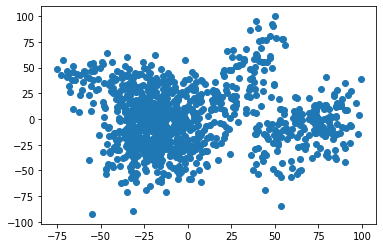

In [14]:
from bokeh.transform import factor_cmap, factor_mark
from bokeh.plotting import figure, show, output_file, save

output_file('Dashboard.html')
pca = PCA(n_components=None, svd_solver='full')
pca_components = pca.fit_transform(normalized)
plt.scatter(pca_components[:,0], pca_components[:,1])

pca = PCA(n_components=0.9999, svd_solver='full')
pca_components = pca.fit_transform(normalized)
print(f'shape of 99.99% of the variation: {pca_components.shape}')
pd.DataFrame(pca_components, index=gene_expression.index).to_csv("/data/g0017139/MAFIA/gene_expression_PCA.dat", sep = " ",header=False, index=False)
plt.show()

In [15]:
from babyplots import Babyplot
bp = Babyplot()
bp.add_plot(pca_components[:,[0, 1, 2]].tolist(), "pointCloud", "categories", 
            colors1, options={'size': 4, 'colorScale': 'tab20'})
bp

<IPython.core.display.Javascript object>

### UMAP to explore the data

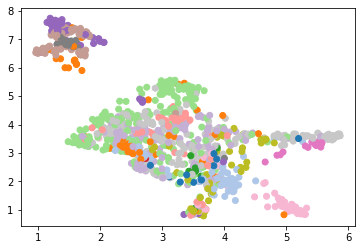

In [16]:
um = umap.UMAP(n_components=3,n_neighbors=90, min_dist=0.1,  random_state=42)
umap_components = um.fit_transform(normalized)
plt.scatter(umap_components[:,0], umap_components[:,1], c=colors)
plt.show()

In [17]:
bp = Babyplot()
bp.add_plot(umap_components[:,[0, 1, 2]].tolist(), "pointCloud", "categories", 
            colors1, options={'size': 4, 'colorScale': 'tab20'})
bp

<IPython.core.display.Javascript object>

## Hierarchical clustering

In [18]:
results_grid = {}
clusters, results_grid['Hierarch'] =  merge_Results('/home/g0017139/UMCG_Thesis/Working_Code/Results/Set1/', 'Hierarch', normalized)

In [19]:
results_grid['Hierarch'].sort_values('silhouette_score', axis=0, ascending=False).head(4)

n_clusters  silhouette_score  calinski_harabasz_score  \
13           2          0.102570                64.930801   
10           4          0.054215                45.541359   
9            6          0.052476                36.334550   
3            5          0.049485                39.454022   

    davies_bouldin_score  
13              3.711160  
10              3.909684  
9               4.203006  
3               4.438095

In [20]:
results_grid['Hierarch'].sort_values('calinski_harabasz_score', axis=0, ascending=False).head(4)

n_clusters  silhouette_score  calinski_harabasz_score  \
13           2          0.102570                64.930801   
8            3          0.038095                47.205457   
10           4          0.054215                45.541359   
3            5          0.049485                39.454022   

    davies_bouldin_score  
13              3.711160  
8               4.355983  
10              3.909684  
3               4.438095

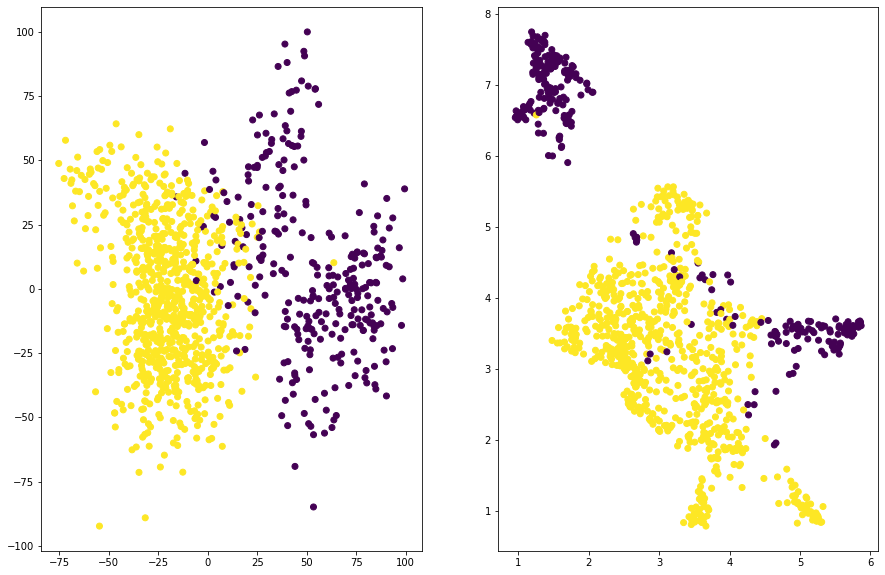

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.scatter(pca_components[:,0], pca_components[:,1], c=clusters['2'].values)
ax2.scatter(umap_components[:,0], umap_components[:,1], c=clusters['2'].values)
plt.show()

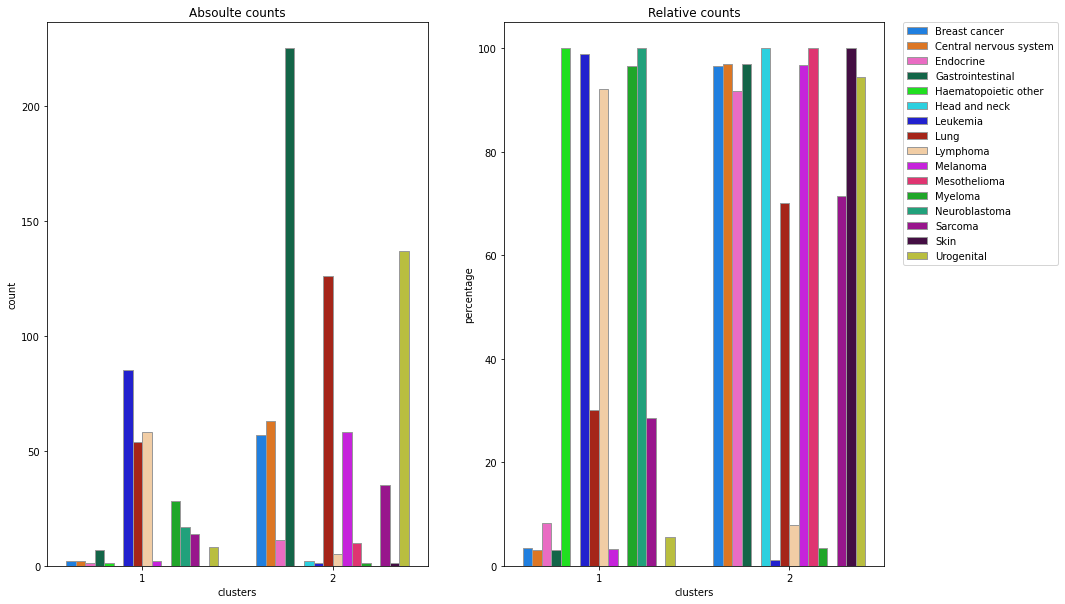

In [22]:
result['clusters'] = clusters['2'].values
make_countplot(result, 'clusters', 'TYPE')

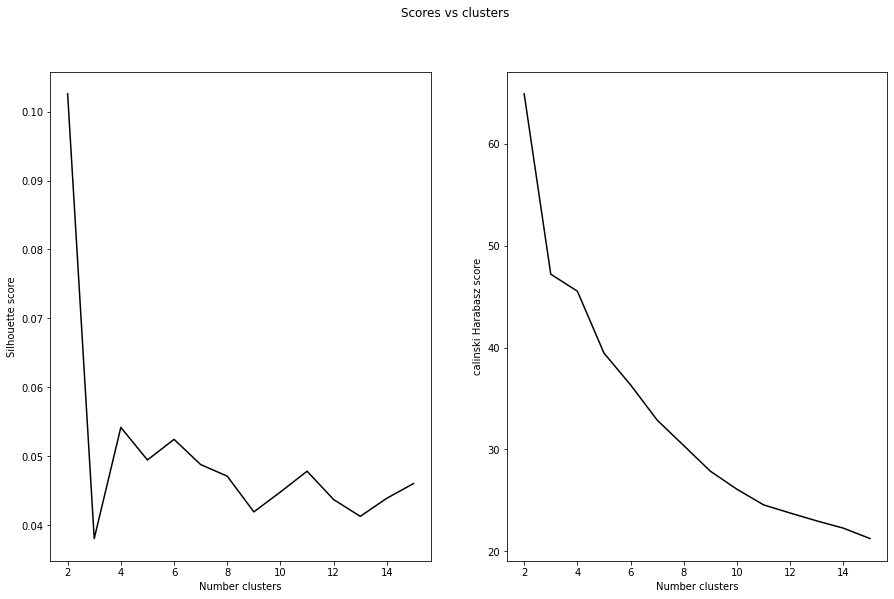

In [23]:
cluster_plot(results_grid['Hierarch'])

## K-means

In [24]:
with open("/home/g0017139/UMCG_Thesis/Working_Code/Results/Set1/kmeans1634075432.630639.pkl", 'rb') as f:
        results_grid['kMeans'] = pickle.load(f)

In [25]:
results_grid['kMeans'].sort_values('silhouette_score', axis=0, ascending=False).head(4)

silhouette_score  calinski_harabasz_score  davies_bouldin_score   Fit_Time  \
1          0.111301                66.925385              3.049233   5.105146   
2          0.111301                66.925385              3.049233   5.705358   
3          0.111301                66.925385              3.049233  11.963032   
0          0.109186                67.610557              3.551061   3.861646   

   n_clusters  batch_size  
1           2         256  
2           2         512  
3           2        1024  
0           2         128

In [26]:
results_grid['kMeans'].sort_values('calinski_harabasz_score', axis=0, ascending=False).head(4)

silhouette_score  calinski_harabasz_score  davies_bouldin_score   Fit_Time  \
0          0.109186                67.610557              3.551061   3.861646   
1          0.111301                66.925385              3.049233   5.105146   
2          0.111301                66.925385              3.049233   5.705358   
3          0.111301                66.925385              3.049233  11.963032   

   n_clusters  batch_size  
0           2         128  
1           2         256  
2           2         512  
3           2        1024

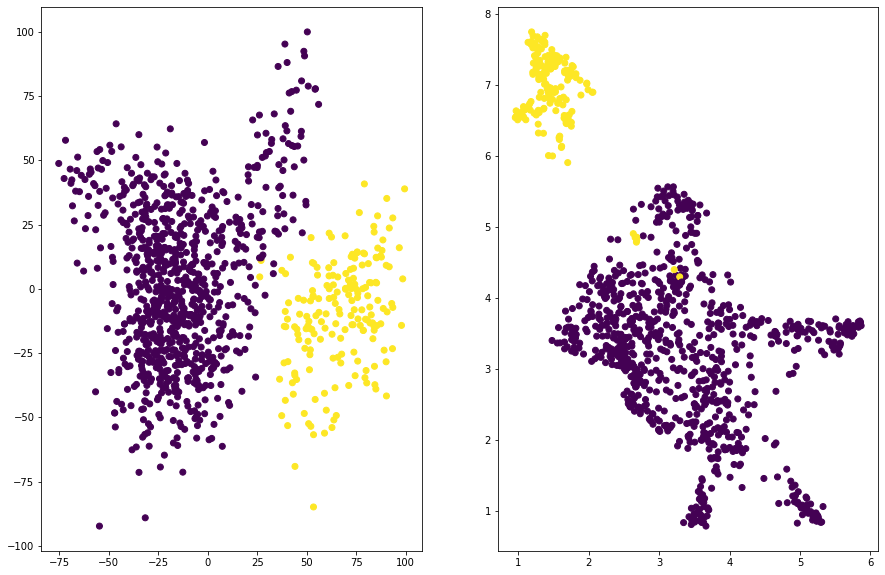

In [27]:
kmeans = MiniBatchKMeans(n_clusters=2,
                         random_state=0,
                         batch_size=512)
kmeans.fit(normalized)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.scatter(pca_components[:,0], pca_components[:,1], c=kmeans.labels_)
ax2.scatter(umap_components[:,0], umap_components[:,1], c=kmeans.labels_)
plt.show()

In [28]:
get_score(normalized, kmeans.labels_)

{'silhouette_score': 0.11130060233904177,
 'calinski_harabasz_score': 66.9253850610066,
 'davies_bouldin_score': 3.0492333716394975}

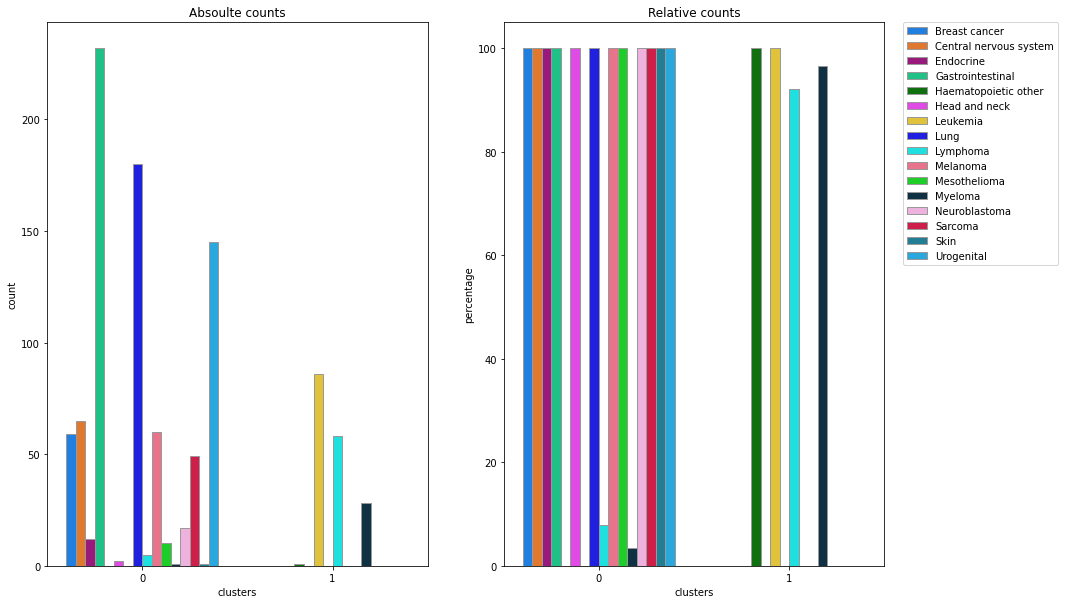

In [29]:
result['clusters'] = kmeans.labels_
make_countplot(result, 'clusters', 'TYPE')

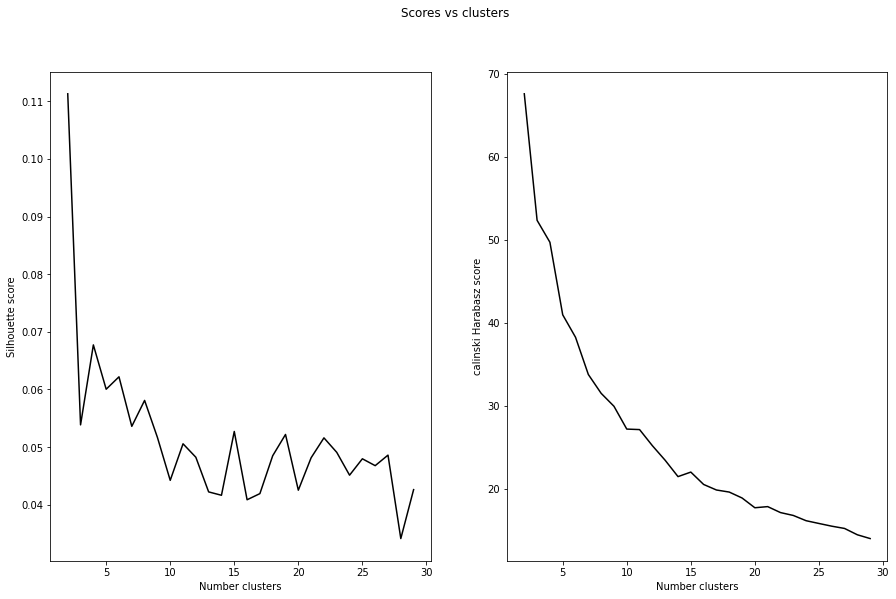

In [30]:
cluster_plot(results_grid['kMeans'])

## UMAP + DBSCAN

In [31]:
with open('/home/g0017139/UMCG_Thesis/Working_Code/Results/Set1/dbscan1634100513.7451205.pkl', 'rb') as f:
        results_grid['dbscan'] = pickle.load(f)

In [32]:
results_grid['dbscan'].sort_values('silhouette_score', axis=0, ascending=False).head(4)

silhouette_score  calinski_harabasz_score  davies_bouldin_score  \
628          0.111301                66.925385              3.049233   
68           0.111301                66.925385              3.049233   
146          0.111301                66.925385              3.049233   
71           0.111301                66.925385              3.049233   

      Fit_Time  DimReduction__n_neighbors  DimReduction__min_dist  \
628  19.969309                         50                     0.1   
68   20.589879                         25                     0.1   
146  17.906788                         25                     0.1   
71   20.044384                         25                     0.1   

     DimReduction__n_components  Clustering__min_cluster_size  \
628                           2                            50   
68                           10                            25   
146                           2                           100   
71                           10                            25   

     Clustering__min_samples  Clustering__cluster_selection_epsilon  \
628                      100                                    1.0   
68                       100                                    0.5   
146                       25                                    0.5   
71                       100                                    1.0   

    Clustering__cluster_selection_method  n_clusters  
628                                  eom           2  
68                                   eom           2  
146                                  eom           2  
71                                  leaf           2

In [34]:
results_grid['dbscan'].sort_values('calinski_harabasz_score', axis=0, ascending=False).head(4)

silhouette_score  calinski_harabasz_score  davies_bouldin_score  \
100          0.111301                66.925385              3.049233   
106          0.111301                66.925385              3.049233   
140          0.111301                66.925385              3.049233   
122          0.111301                66.925385              3.049233   

      Fit_Time  DimReduction__n_neighbors  DimReduction__min_dist  \
100  21.066302                         25                     0.1   
106  20.861779                         25                     0.1   
140  18.492071                         25                     0.1   
122  17.493623                         25                     0.1   

     DimReduction__n_components  Clustering__min_cluster_size  \
100                          10                           100   
106                          10                           100   
140                           2                            50   
122                           2                            25   

     Clustering__min_samples  Clustering__cluster_selection_epsilon  \
100                       50                                    1.0   
106                      100                                    1.0   
140                      100                                    0.5   
122                      100                                    0.5   

    Clustering__cluster_selection_method  n_clusters  
100                                  eom           2  
106                                  eom           2  
140                                  eom           2  
122                                  eom           2

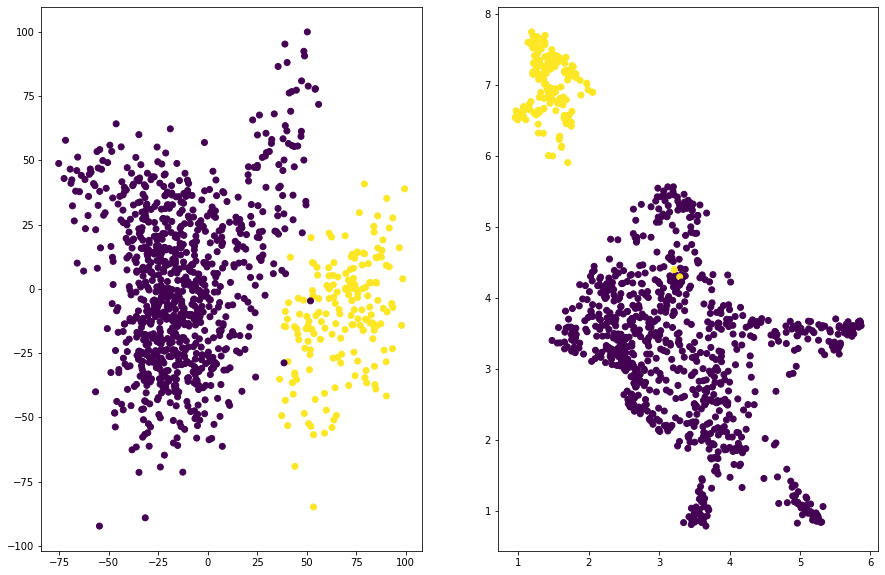

In [43]:
pipe = Pipeline([('DimReduction', 
                  umap.UMAP(
                      n_neighbors=25,
                      min_dist=0.1,
                      n_components=10,
                      random_state=1)),
                 ('Clustering', 
                 hdbscan.HDBSCAN(min_cluster_size=100,
                                min_samples=50,
                                cluster_selection_epsilon=1.0,
                                cluster_selection_method='eom'))
                ])
pipe.fit(normalized)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.scatter(pca_components[:,0], pca_components[:,1], c=pipe['Clustering'].labels_)
ax2.scatter(umap_components[:,0], umap_components[:,1], c=pipe['Clustering'].labels_)
plt.show()

In [44]:
get_score(normalized, pipe['Clustering'].labels_)

{'silhouette_score': 0.11089767308220627,
 'calinski_harabasz_score': 65.9185592477536,
 'davies_bouldin_score': 3.02777283550824}

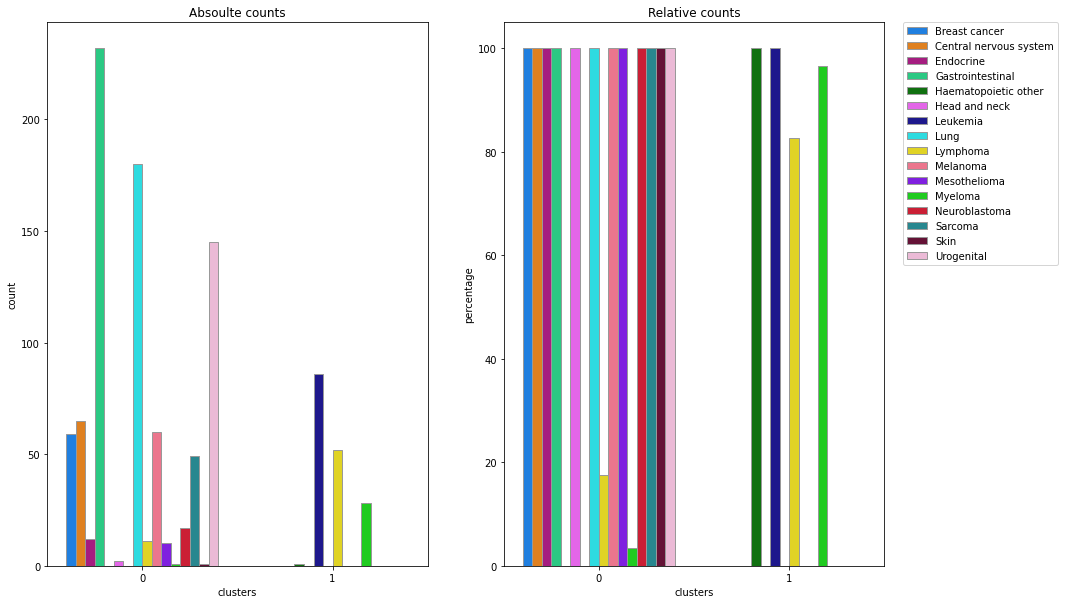

In [45]:
result['clusters'] = pipe['Clustering'].labels_
make_countplot(result, 'clusters', 'TYPE')

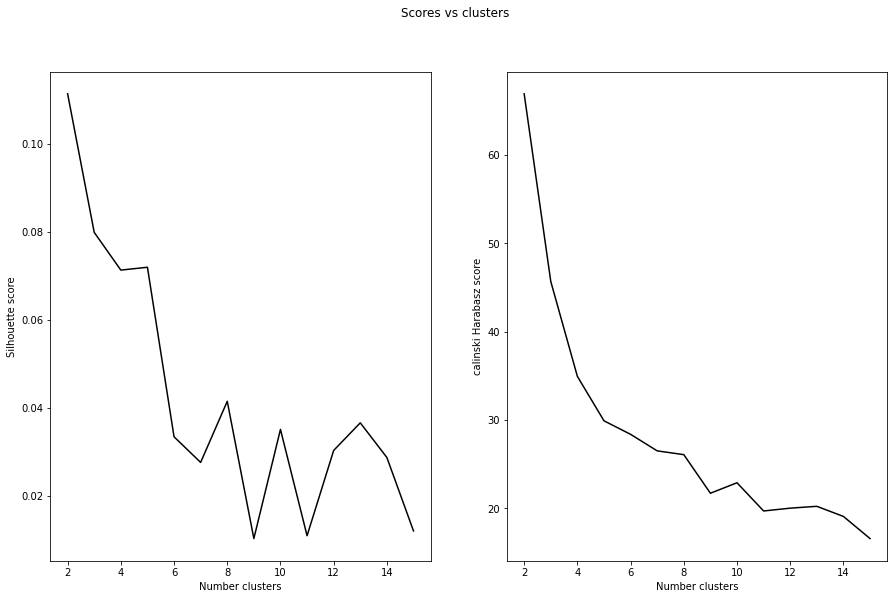

In [46]:
cluster_plot(results_grid['dbscan'])

## HDDC

In [87]:
clusters, results_grid['hddc'], df  =  merge_Results('/home/g0017139/UMCG_Thesis/Working_Code/Results/Set1/', 'HDDC', normalized)

NameError: name 'results_grid' is not defined

In [88]:
_, __, df  =  merge_Results('/home/g0017139/UMCG_Thesis/Working_Code/Results/Set1/', 'HDDC', normalized)

In [89]:
df.head()

model    K  threshold            LL           BIC           ICL  rank  \
168   12.0  2.0       0.01 -2.344247e+07 -5.304252e+07 -5.304252e+07     1   
169    8.0  2.0       0.01 -2.344605e+07 -5.304939e+07 -5.304939e+07     2   
170    2.0  2.0       0.01 -2.344682e+07 -5.305092e+07 -5.305092e+07     3   
171   14.0  2.0       0.01 -2.347949e+07 -5.311654e+07 -5.311654e+07     4   
172   10.0  2.0       0.01 -2.348307e+07 -5.312342e+07 -5.312342e+07     5   

     complexity  
168    883109.0  
169    883068.0  
170    883067.0  
171    883108.0  
172    883067.0

In [48]:
results_grid['hddc'].sort_values('silhouette_score', axis=0, ascending=False).head(4)

n_clusters  silhouette_score  calinski_harabasz_score  davies_bouldin_score
4           2          0.111406                67.637558              3.509215
7           3          0.108966                52.670269              3.333978
5           4          0.065503                49.199710              3.626956
3           6          0.049288                36.332607              3.870945

In [50]:
results_grid['hddc'].sort_values('calinski_harabasz_score', axis=0, ascending=False).head(4)

n_clusters  silhouette_score  calinski_harabasz_score  davies_bouldin_score
4           2          0.111406                67.637558              3.509215
7           3          0.108966                52.670269              3.333978
5           4          0.065503                49.199710              3.626956
1           5          0.047513                38.843831              3.784591

In [51]:
df.head()

model    K  threshold            LL           BIC           ICL  rank  \
84   12.0  2.0       0.01 -2.344247e+07 -5.304252e+07 -5.304252e+07     1   
85    8.0  2.0       0.01 -2.344605e+07 -5.304939e+07 -5.304939e+07     2   
86    2.0  2.0       0.01 -2.344682e+07 -5.305092e+07 -5.305092e+07     3   
87   14.0  2.0       0.01 -2.347949e+07 -5.311654e+07 -5.311654e+07     4   
88   10.0  2.0       0.01 -2.348307e+07 -5.312342e+07 -5.312342e+07     5   

    complexity  
84    883109.0  
85    883068.0  
86    883067.0  
87    883108.0  
88    883067.0

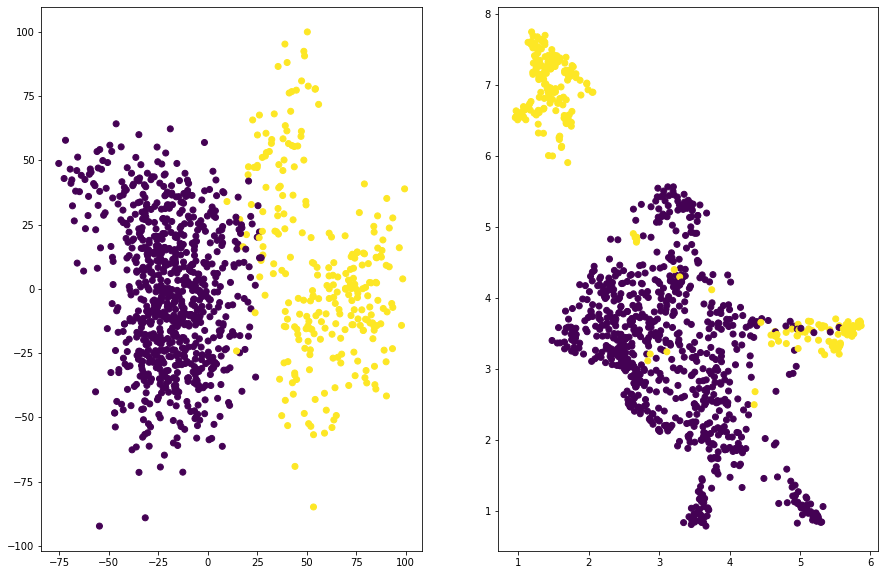

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.scatter(pca_components[:,0], pca_components[:,1], c=clusters['2'].values)
ax2.scatter(umap_components[:,0], umap_components[:,1], c=clusters['2'].values)
plt.show()

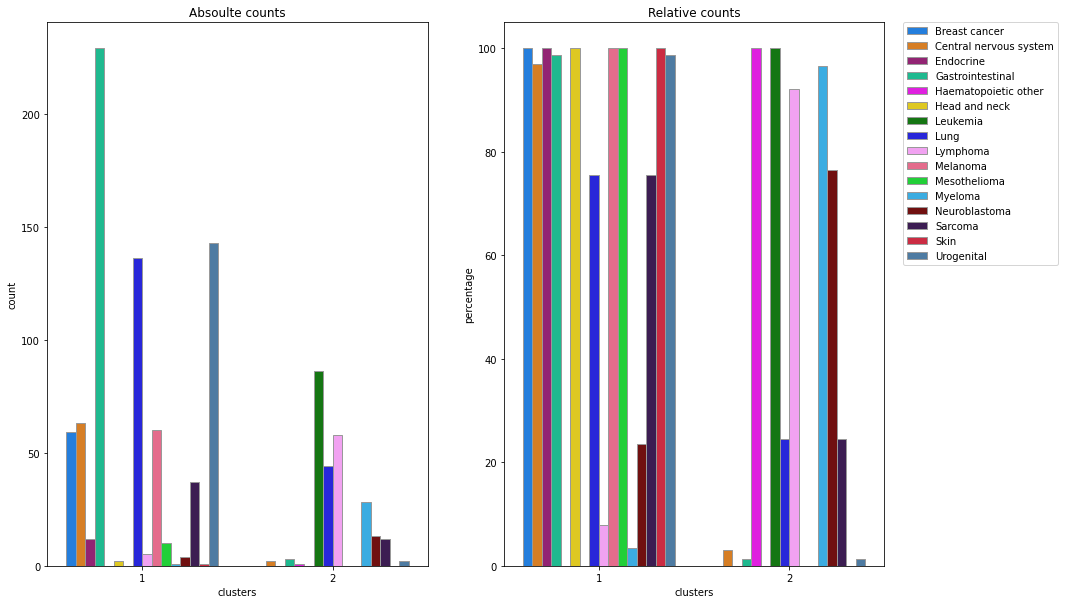

In [53]:
result['clusters'] = clusters['2'].values
make_countplot(result, 'clusters', 'TYPE')

In [54]:
get_score(normalized, clusters['2'].values)

{'silhouette_score': 0.1114064690178124,
 'calinski_harabasz_score': 67.63755797424253,
 'davies_bouldin_score': 3.509215345401019}

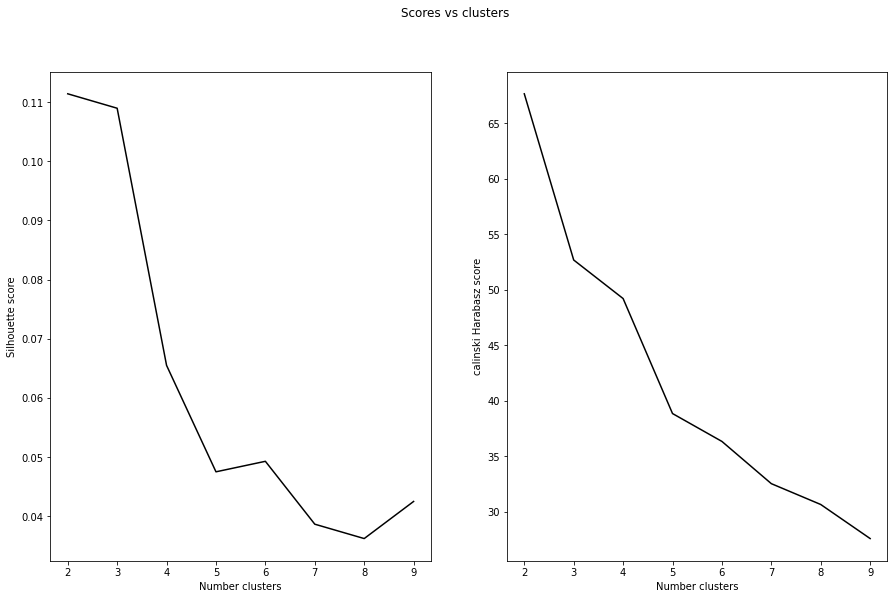

In [55]:
cluster_plot(results_grid['hddc'])

# Set2

In [53]:
from dask.distributed import Client, progress
import dask.dataframe as dd
FIRST_RUN = False
if FIRST_RUN: 
    client = Client(threads_per_worker=1)
    GPL570 = dd.read_csv("/data/g0017139/Set2/GPL570__Affy_hgu133plus2_NoDuplicatesamples_CleanedIdentifiers_RMA-sketch_NormalAndCancer_QCed.txt",
        sep='\t', header=0)
    Mapping = pd.read_csv("/data/g0017139/Set2/Genomic_Mapping_hgu133plus2_using_jetscore_30032018.txt",
        sep='\t', header=0)
    Mapping = Mapping[Mapping['top_probe_indicator'] == 1]
    Probe_to_entID = pd.Series(Mapping['ENTREZID'].values,index=Mapping['PROBESET']).to_dict()
    GPL570 = GPL570[GPL570['Unnamed: 0'].isin(Mapping['PROBESET'])]
    GPL570 = GPL570.compute()
    GPL570 = GPL570.set_index('Unnamed: 0')
    GPL570 = GPL570.T
    GPL570.columns = [Probe_to_entID[x] for x in GPL570.columns]
    GPL570.to_csv("/data/g0017139/GPL570_clean.dat", sep = " ")
    GPL570.to_parquet("/data/g0017139/GPL570_clean.parquet")
    
    scaler = StandardScaler()
    normalized_set2 = scaler.fit_transform(GPL570)
    normalized_set2 = pd.DataFrame(normalized_set2)
    normalized_set2.columns = [str(x) for x in normalized_set2.columns]
    normalized_set2.to_csv("/data/g0017139/GPL570_norm.dat", sep = " ",header=False, index=False)
    normalized_set2.to_parquet('/data/g0017139/GPL570_norm.parquet')
else:
    normalized_set2 = pd.read_parquet("/data/g0017139/GPL570_norm.parquet")
    GPL570 = pd.read_parquet("/data/g0017139/GPL570_clean.parquet")
    
GPL570_IDENTIFIER = pd.read_csv("/data/g0017139/Set2/GPL570__Sample_To_TumorType.csv").set_index('GSM_IDENTIFIER')
GPL570_with_type = GPL570.join(GPL570_IDENTIFIER)

In [54]:
GPL570_IDENTIFIER = pd.read_csv("/data/g0017139/Set2/GPL570__Sample_To_TumorType.csv").set_index('GSM_IDENTIFIER')
GPL570_with_type = GPL570.join(GPL570_IDENTIFIER)

In [55]:
GPL570_with_type.head()

2597        60       780     3310     2978     7318     2101  \
Unnamed: 0                                                                     
GSM1001510  12.48515  12.22566  10.22445  6.23085  3.08293  8.38099  7.47182   
GSM1001511  12.32346  12.44495   9.88120  6.26010  3.07067  8.56414  7.42433   
GSM1001512  12.33341  11.98822  10.07950  6.11869  3.19944  8.41667  7.59330   
GSM1001513  12.45417  12.04678  10.03383  6.35478  3.01793  8.13622  6.96998   
GSM1001514  12.63870  11.73320   9.99284  6.22363  3.02340  8.27952  7.45541   

                2621     10594       826  ...  101926928  101929076   643201  \
Unnamed: 0                                ...                                  
GSM1001510  10.62020  10.18566  11.60310  ...    2.97168    5.26769  3.07470   
GSM1001511  10.89454  10.36638  11.55575  ...    2.76673    4.98565  3.09682   
GSM1001512  10.81625  10.43955  11.54753  ...    2.86148    5.10979  3.20003   
GSM1001513  10.21740  10.26386  11.02802  ...    2.90639    5.32259  3.20032   
GSM1001514  10.84507  10.28861  11.52889  ...    2.96498    5.23723  3.39996   

             643365   338579      417    83734   400759     9512    TYPE  
Unnamed: 0                                                                
GSM1001510  4.47923  3.46930  4.86649  5.85619  4.98293  4.02664  Normal  
GSM1001511  4.43522  3.30832  4.67281  5.85905  4.85582  3.97145  Normal  
GSM1001512  4.49753  3.40857  4.90194  5.45407  4.76866  3.93117  Normal  
GSM1001513  4.99881  3.87156  5.12847  5.07526  5.00188  4.28031  Normal  
GSM1001514  4.49823  3.56088  4.59507  5.50669  5.25796  3.53012  Normal  

[5 rows x 19636 columns]

In [ ]:
test = GPL570_with_type['TYPE'].str.split(' - ', expand=True)[0]
test = (['Leukemia' if ('leukemia' in x) else x for x in test])
test = (['Lymphoma' if ('lymphoma' in x) else x for x in test])
test = (['Sarcoma' if ('sarcoma' in x) or ('Sarcoma' in x) else x for x in test])
GPL570_with_type['TYPE2'] = test

In [34]:
normalized_set2.shape

(21592, 19635)

## UMAP

In [ ]:
um = umap.UMAP(n_components=3, random_state=42,  n_neighbors=30, min_dist=0.0)
umap_components = um.fit_transform(normalized_set2)
colors = distinctipy.get_colors(len(set(GPL570_with_type['TYPE2'])), colorblind_type='Deuteranomaly',
                                n_attempts=10_000)
pallette = sns.color_palette(colors)
colorset = {}
colorset1 = {}
for i, x in enumerate(set(GPL570_with_type['TYPE2'])):
    colorset[x] = pallette[i]
    colorset1[x] = i
    
colors = [colorset[x] for x in GPL570_with_type['TYPE2']]
colors1 = [colorset1[x] for x in GPL570_with_type['TYPE2']]

fig = plt.figure(figsize=(15,10))
plt.scatter(umap_components[:,0], umap_components[:,1], c=colors)
plt.show()

## Hierarchical clustering

In [142]:
results_grid_2 = {}
clusters, results_grid_2['Hierarch'] =  merge_Results('/home/g0017139/UMCG_Thesis/Working_Code/Results/Set2/', 'Hierarch', normalized_set2)

In [143]:
results_grid_2['Hierarch'].sort_values('silhouette_score', axis=0, ascending=False).head(4)

n_clusters  silhouette_score  calinski_harabasz_score  \
13           2          0.096876                64.930801   
12          15          0.039052                21.237303   
9            6          0.039044                36.334550   
10           4          0.038910                45.541359   

    davies_bouldin_score  
13              3.711160  
12              3.640547  
9               4.203006  
10              3.909684

In [144]:
results_grid_2['Hierarch'].sort_values('calinski_harabasz_score', axis=0, ascending=False).head(4)

n_clusters  silhouette_score  calinski_harabasz_score  \
13           2          0.096876                64.930801   
8            3          0.025232                47.205457   
10           4          0.038910                45.541359   
3            5          0.035483                39.454022   

    davies_bouldin_score  
13              3.711160  
8               4.355983  
10              3.909684  
3               4.438095

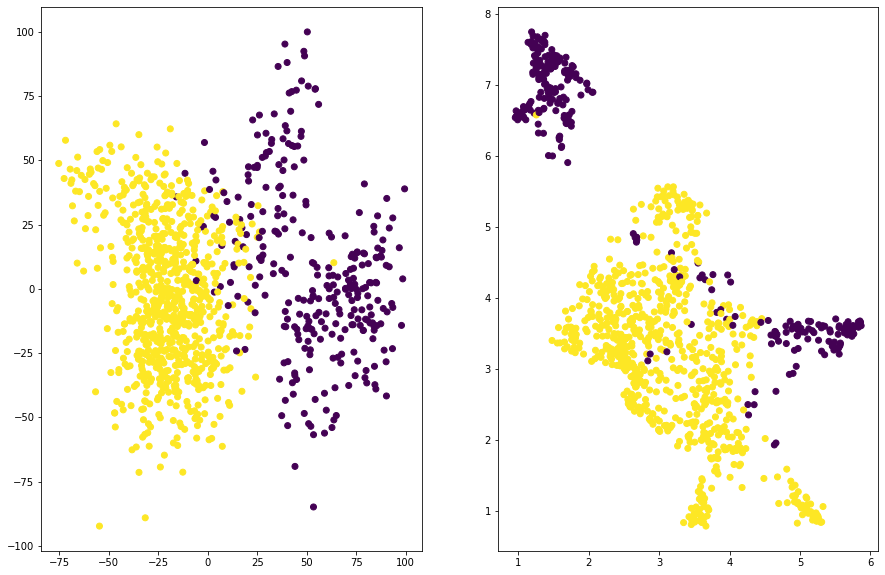

In [145]:
fig = plt.figure(figsize=(15,10))
plt.scatter(umap_components[:,0], umap_components[:,1], c=clusters['2'].values)
plt.show()

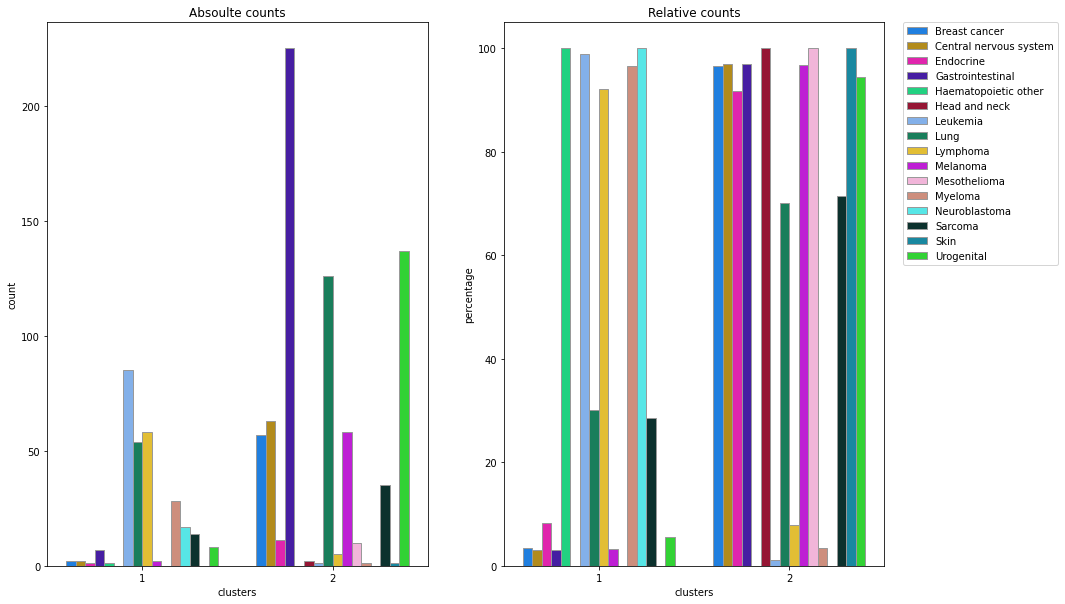

In [147]:
result['clusters'] = clusters['2'].values
make_countplot(GPL570_with_type, 'clusters', 'TYPE2')

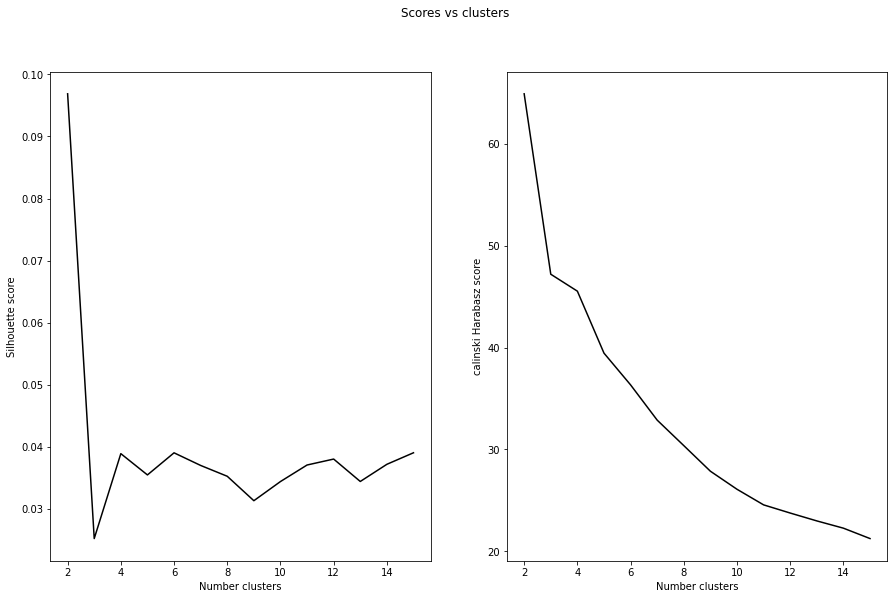

In [148]:
cluster_plot(results_grid_2['Hierarch'])

## Kmeans

In [ ]:
with open("/home/g0017139/UMCG_Thesis/Working_Code/Results/Set2/", 'rb') as f:
        results_grid_2['kMeans'] = pickle.load(f)

In [ ]:
results_grid_2['kMeans'].sort_values('silhouette_score', axis=0, ascending=False).head(4)

In [ ]:
results_grid_2['kMeans'].sort_values('calinski_harabasz_score', axis=0, ascending=False).head(4)

In [56]:
kmeans = MiniBatchKMeans(n_clusters=3,
                         random_state=0,
                         batch_size=256)
kmeans.fit(normalized_set2)
# fig = plt.figure(figsize=(15,10))
# plt.scatter(umap_components[:,0], umap_components[:,1], c=kmeans.labels_)
# plt.show()

MiniBatchKMeans(batch_size=256, n_clusters=3, random_state=0)

In [57]:
for x in range(5):
    start_time1 = time.time()
    temp = get_score(normalized_set2, kmeans.labels_)
    end_time1 = time.time() - start_time1
    print(end_time1)
    print(temp)
    print("__________")

296.967401266098
{'silhouette_score': 0.13295967185780241, 'calinski_harabasz_score': 1875.6846708036805, 'davies_bouldin_score': 2.5452457372669395}
__________
300.7262988090515
{'silhouette_score': 0.1280192233570295, 'calinski_harabasz_score': 1875.6846708036805, 'davies_bouldin_score': 2.5452457372669395}
__________
301.4017517566681
{'silhouette_score': 0.1301133771199349, 'calinski_harabasz_score': 1875.6846708036805, 'davies_bouldin_score': 2.5452457372669395}
__________
302.09098172187805
{'silhouette_score': 0.13254447201115685, 'calinski_harabasz_score': 1875.6846708036805, 'davies_bouldin_score': 2.5452457372669395}
__________
300.09377002716064
{'silhouette_score': 0.1323990661565001, 'calinski_harabasz_score': 1875.6846708036805, 'davies_bouldin_score': 2.5452457372669395}
__________


In [ ]:
# Make the figure
GPL570_with_type['clusters'] = kmeans.labels_
make_countplot(GPL570_with_type, 'clusters', 'TYPE2')

In [ ]:
cluster_plot(results_grid_2['kMeans'])

## UMAP + DBSCAN

In [ ]:
with open('/home/g0017139/UMCG_Thesis/Working_Code/Results/Set2/', 'rb') as f:
        results_grid_2['dbscan'] = pickle.load(f)

In [ ]:
results_grid_2['dbscan'].sort_values('silhouette_score', axis=0, ascending=False).head(4)

In [ ]:
results_grid_2['dbscan'].sort_values('calinski_harabasz_score', axis=0, ascending=False).head(4)

In [ ]:
pipe = Pipeline([('DimReduction', 
                  umap.UMAP(
                      n_neighbors=30,
                      min_dist=0.0,
                      n_components=1,
                      random_state=1)),
                 ('Clustering', 
                 hdbscan.HDBSCAN(min_cluster_size=50,
                                min_samples=75,
                                cluster_selection_epsilon=1.0,
                                cluster_selection_method='eom'))
                ])
pipe.fit(normalized_set2)

fig = plt.figure(figsize=(15,10))
plt.scatter(umap_components[:,0], umap_components[:,1], c=pipe['Clustering'].labels_)
plt.show()

In [ ]:
get_score(normalized_set2, pipe['Clustering'].labels_)

In [ ]:
GPL570_with_type['clusters'] = pipe['Clustering'].labels_
make_countplot(GPL570_with_type, 'clusters', 'TYPE2')

In [ ]:
cluster_plot(results_grid_2['dbscan'])

## HDDC

In [150]:
clusters, results_grid_2['hddc'], df  =  merge_Results('/home/g0017139/UMCG_Thesis/Working_Code/Results/Set2/', 'HDDC', c)

In [152]:
results_grid_2['hddc'].sort_values('silhouette_score', axis=0, ascending=False).head(4)

n_clusters  silhouette_score  calinski_harabasz_score  davies_bouldin_score
2           2          0.105046                67.637558              3.509215
5           3          0.104774                52.670269              3.333978
3           4          0.048322                49.199710              3.626956
0           5          0.037439                38.843831              3.784591

In [153]:
results_grid_2['hddc'].sort_values('calinski_harabasz_score', axis=0, ascending=False).tail(4)

n_clusters  silhouette_score  calinski_harabasz_score  davies_bouldin_score
3           4          0.048322                49.199710              3.626956
0           5          0.037439                38.843831              3.784591
1           6          0.037125                36.332607              3.870945
4           7          0.033155                32.529838              3.159462

In [154]:
df.head()

model    K  threshold            LL           BIC           ICL  rank  \
42    12.0  2.0       0.01 -2.344247e+07 -5.304252e+07 -5.304252e+07     1   
252   12.0  2.0       0.01 -2.344247e+07 -5.304252e+07 -5.304252e+07     2   
43     8.0  2.0       0.01 -2.344605e+07 -5.304939e+07 -5.304939e+07     3   
253    8.0  2.0       0.01 -2.344605e+07 -5.304939e+07 -5.304939e+07     4   
44     2.0  2.0       0.01 -2.344682e+07 -5.305092e+07 -5.305092e+07     5   

     complexity  
42     883109.0  
252    883109.0  
43     883068.0  
253    883068.0  
44     883067.0

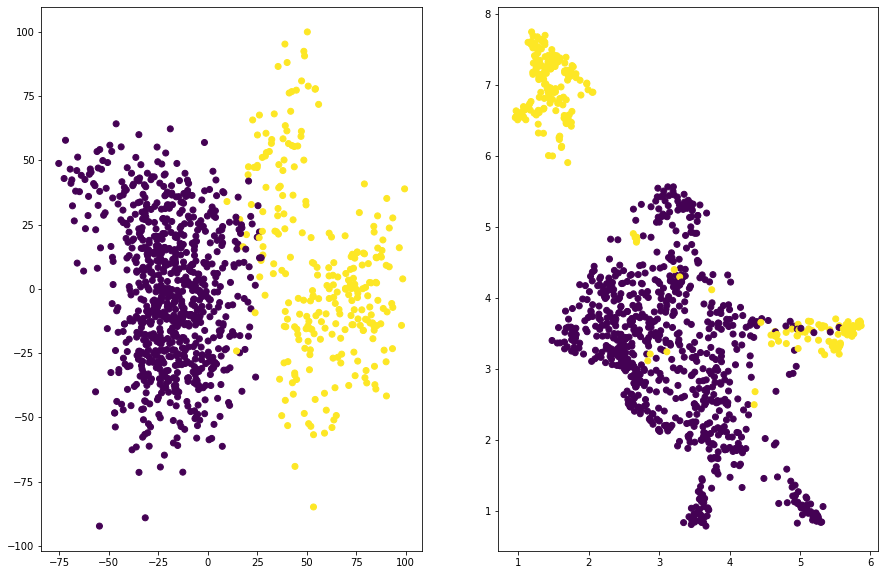

In [160]:
fig = plt.figure(figsize=(15,10))
plt.scatter(umap_components[:,0], umap_components[:,1], c=clusters['2'].values)
plt.show()

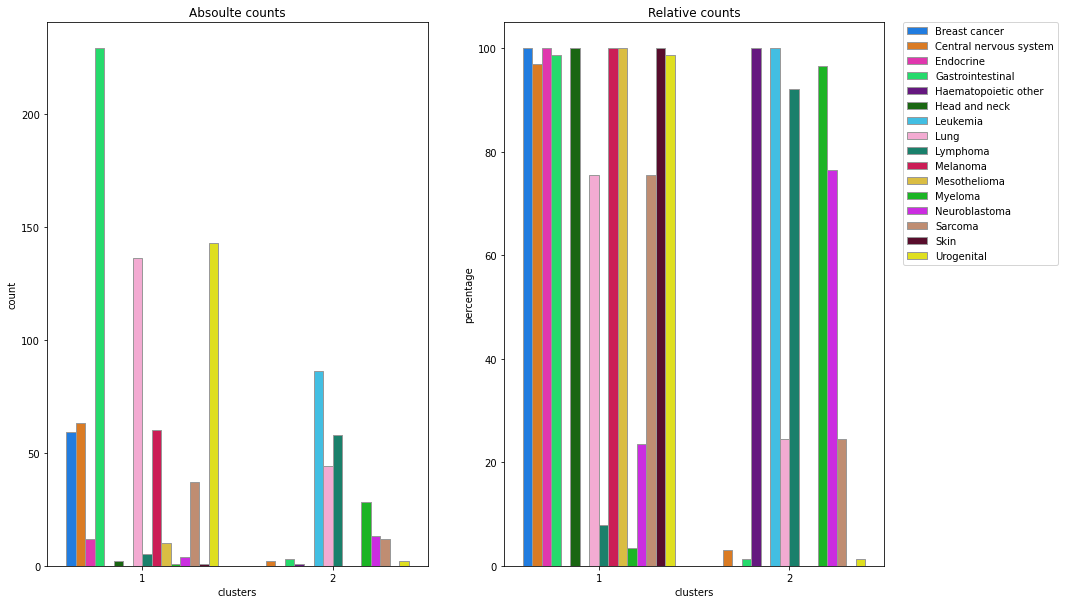

In [157]:
GPL570_with_type['clusters'] = clusters['2'].values
make_countplot(GPL570_with_type, 'clusters', 'TYPE')

In [158]:
get_score(normalized_set2, clusters['2'].values)

{'silhouette_score': 0.10504558974643793,
 'calinski_harabasz_score': 67.63755797424253,
 'davies_bouldin_score': 3.509215345401019}

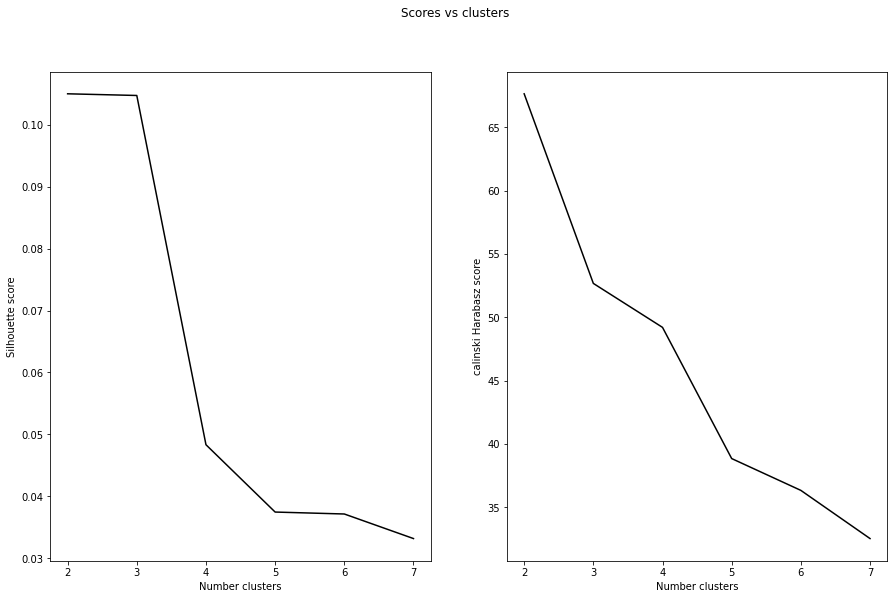

In [159]:
cluster_plot(results_grid_2['hddc'])

# Mixing set

In [58]:
mixing_mat = pd.read_csv('/data/g0017139/Set2/Consensus mixing matrix.txt', sep='\t').set_index('Unnamed: 0')
mixing_mat.to_csv("/data/g0017139/mixing_mat.dat", sep = " ",header=False, index=False)
mixing_with_type = mixing_mat.join(GPL570_IDENTIFIER)
mixing_mat.head()

Consensus IC 1  Consensus IC 2  Consensus IC 3  Consensus IC 4  \
Unnamed: 0                                                                   
GSM1003005       -0.168400        0.023047        0.016927        0.019391   
GSM1003006       -0.149832        0.016418        0.016576        0.007199   
GSM1003007       -0.185606        0.024747        0.010050        0.015501   
GSM1003008       -0.180318        0.027954        0.009539        0.014140   
GSM1003009       -0.138560        0.022358        0.015707        0.001537   

            Consensus IC 5  Consensus IC 6  Consensus IC 7  Consensus IC 8  \
Unnamed: 0                                                                   
GSM1003005       -0.004509       -0.014378       -0.000242        0.033359   
GSM1003006       -0.012532       -0.017766       -0.000747        0.025327   
GSM1003007       -0.005777       -0.032933       -0.008796        0.018791   
GSM1003008       -0.007732       -0.021536       -0.002905        0.023250   
GSM1003009       -0.011366       -0.007487        0.005489        0.033997   

            Consensus IC 9  Consensus IC 10  ...  Consensus IC 402  \
Unnamed: 0                                   ...                     
GSM1003005       -0.002831         0.030181  ...          0.006862   
GSM1003006        0.034158         0.023662  ...          0.010719   
GSM1003007        0.020512         0.016309  ...          0.010560   
GSM1003008        0.016701         0.026545  ...          0.011428   
GSM1003009        0.058144        -0.002601  ...          0.007621   

            Consensus IC 403  Consensus IC 404  Consensus IC 405  \
Unnamed: 0                                                         
GSM1003005          0.007187          0.025537         -0.116209   
GSM1003006          0.005401          0.022445         -0.139800   
GSM1003007         -0.008056          0.020337         -0.098043   
GSM1003008         -0.006186          0.024674         -0.055474   
GSM1003009          0.000741          0.008987         -0.225030   

            Consensus IC 406  Consensus IC 407  Consensus IC 408  \
Unnamed: 0                                                         
GSM1003005          0.124672         -0.006297          0.005190   
GSM1003006          0.139337          0.003000          0.010428   
GSM1003007          0.017152          0.009456          0.005390   
GSM1003008          0.063800          0.010407          0.010418   
GSM1003009          0.065596          0.008740          0.035633   

            Consensus IC 409  Consensus IC 410  Consensus IC 411  
Unnamed: 0                                                        
GSM1003005          0.002781         -0.001013          0.071508  
GSM1003006          0.023488         -0.006811          0.071267  
GSM1003007          0.003869         -0.017888          0.024748  
GSM1003008          0.008887         -0.016752          0.017983  
GSM1003009          0.000604         -0.017028          0.033489  

[5 rows x 411 columns]

## Kmeans

In [12]:
results_grid_3 = {}

In [13]:
with open("/home/g0017139/UMCG_Thesis/Working_Code/Results/Set3/kmeans1633080539.0028353.pkl", 'rb') as f:
        results_grid_3['kMeans'] = pickle.load(f)

In [14]:
results_grid_3['kMeans'].sort_values('silhouette_score', axis=0, ascending=False).head(4)

silhouette_score  calinski_harabasz_score  davies_bouldin_score  Fit_Time  \
2          0.197677              1333.994266              2.025419  0.079135   
3          0.164983              1361.239351              2.132719  0.112448   
0          0.161739              1361.788266              2.140628  1.711575   
1          0.154715              1355.976603              2.160696  0.077748   

   n_clusters  batch_size  
2           2         512  
3           2        1024  
0           2         128  
1           2         256

In [15]:
results_grid_3['kMeans'].sort_values('calinski_harabasz_score', axis=0, ascending=False).head(4)

silhouette_score  calinski_harabasz_score  davies_bouldin_score  Fit_Time  \
0          0.161739              1361.788266              2.140628  1.711575   
3          0.164983              1361.239351              2.132719  0.112448   
1          0.154715              1355.976603              2.160696  0.077748   
2          0.197677              1333.994266              2.025419  0.079135   

   n_clusters  batch_size  
0           2         128  
3           2        1024  
1           2         256  
2           2         512

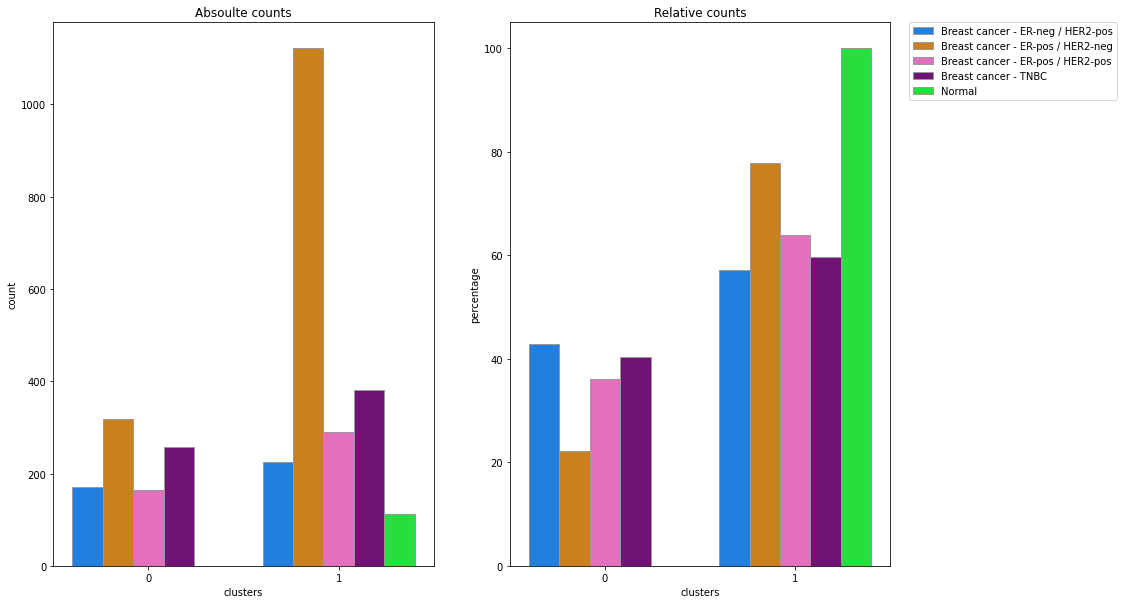

In [16]:
kmeans = MiniBatchKMeans(n_clusters=2,
                         random_state=0,
                         batch_size=512)
kmeans.fit(mixing_mat)
mixing_with_type['clusters'] = kmeans.labels_
make_countplot(mixing_with_type, 'clusters', 'TYPE')

In [17]:
get_score(mixing_mat, kmeans.labels_)

{'silhouette_score': 0.14989164962724896,
 'calinski_harabasz_score': 1333.994266220463,
 'davies_bouldin_score': 2.025418652841891}

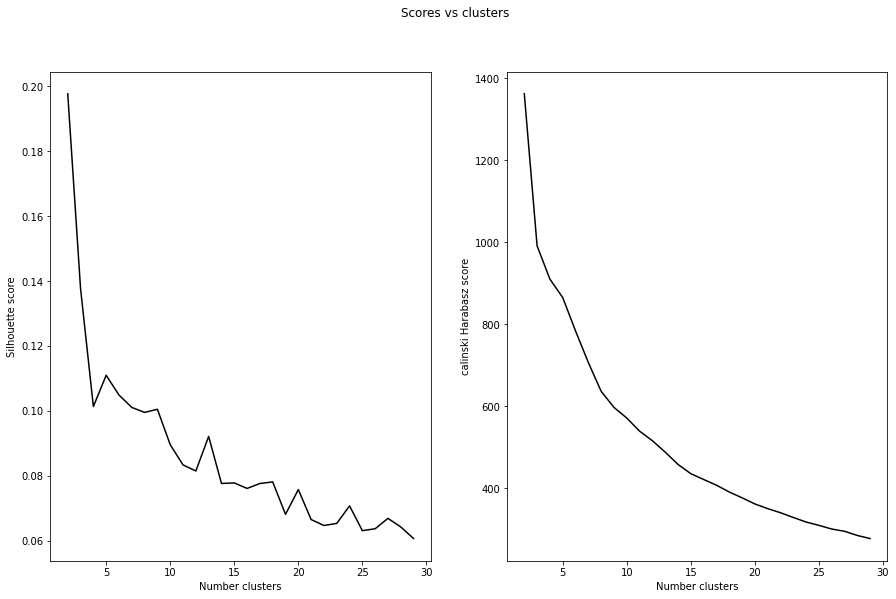

In [18]:
cluster_plot(results_grid_3['kMeans'])

## Hierachical

In [ ]:
clusters, results_grid_3['Hierarch'] =  merge_Results('/home/g0017139/UMCG_Thesis/Working_Code/Results/Set3/', 'Hierarch', mixing_mat)

1
1
1
1
1
1
1
1
1
1
1
1


In [20]:
results_grid_3['hierarch'].sort_values('silhouette_score', axis=0, ascending=False).head(4)

KeyError: 'hierarch'

In [ ]:
results_grid_3['hierarch'].sort_values('calinski_harabasz_score', axis=0, ascending=False).head(4)

In [ ]:
mixing_with_type['clusters'] = clusters['2'].values
make_countplot(mixing_with_type, 'clusters', 'TYPE')

In [ ]:
cluster_plot(results_grid_3['hierarch'])

## UMAP + DBSCAN

In [ ]:
with open('/home/g0017139/UMCG_Thesis/Working_Code/Results/Set3/dbscan1633091030.1037846.pkl', 'rb') as f:
        results_grid_3['dbscan'] = pickle.load(f)

In [ ]:
results_grid_3['dbscan'].sort_values('silhouette_score', axis=0, ascending=False).head()

In [ ]:
results_grid_3['dbscan'].sort_values('calinski_harabasz_score', axis=0, ascending=False).head(4)

In [ ]:
pipe = Pipeline([('DimReduction', 
                  umap.UMAP(
                      n_neighbors=50,
                      min_dist=0.5,
                      n_components=50,
                      random_state=42)),
                 ('Clustering', 
                 hdbscan.HDBSCAN(min_cluster_size=25,
                                min_samples=100,
                                cluster_selection_epsilon=1.0,
                                cluster_selection_method='eom'))
                ])
pipe.fit(mixing_mat)

In [ ]:
get_score(mixing_mat, pipe['Clustering'].labels_)

In [ ]:
mixing_with_type['clusters'] = pipe['Clustering'].labels_
make_countplot(mixing_with_type, 'clusters', 'TYPE')

In [ ]:
cluster_plot(results_grid_3['dbscan'])

## HDDC

In [ ]:
clusters, results_grid_3['hddc'], df =  merge_Results('/home/g0017139/UMCG_Thesis/Working_Code/Results/Set3/', 'DDC', mixing_mat)

In [ ]:
results_grid_3['hddc'].sort_values('silhouette_score', axis=0, ascending=False).head()

In [ ]:
results_grid_3['hddc'].sort_values('calinski_harabasz_score', axis=0, ascending=False).head(4)

In [ ]:
df.head(4)

In [ ]:
mixing_with_type['clusters'] = clusters['2']
make_countplot(mixing_with_type, 'clusters', 'TYPE')

In [ ]:
get_score(mixing_mat, clusters)

In [ ]:
cluster_plot(results_grid_3['hddc'])

# Set3

In [9]:
Firs = False
results_grid_4 = {}
if Firs:
    TCGA = pd.read_csv('/data/g0017139/Set2/TCGA__RSEM_genes_RNAseq__duplicate_samples_removed__genes_with_all_zeroes_removed.txt',
                                   sep=None, engine='python', header=0,
    )
    TCGA = TCGA.T
    TCGA.columns = [str(x) for x in TCGA.columns]
    TCGA.to_parquet("/data/g0017139/TCGA__RSEM.parquet")

    scaler = StandardScaler()
    TCGA_norm = scaler.fit_transform(TCGA)
    TCGA_norm = pd.DataFrame(TCGA_norm)
    TCGA_norm.columns = [str(x) for x in TCGA_norm.columns]
    TCGA_norm.to_csv("/data/g0017139/TCGA__RSEM_norm.dat", sep = " ",header=False, index=False)
    TCGA_norm.to_parquet('/data/g0017139/TCGA__RSEM_norm.parquet')
else:
    TCGA = pd.read_parquet("/data/g0017139/TCGA__RSEM.parquet")
    TCGA_norm = pd.read_parquet('/data/g0017139/TCGA__RSEM_norm.parquet')

In [10]:
TCGA.shape

(10817, 20392)

In [11]:
TCGA.head()

100130426  100133144  100134869    10357  \
TCGA-RZ-AB0B-01A-11R-A405-07        0.0     7.9418     4.8264  91.0674   
TCGA-V3-A9ZX-01A-11R-A405-07        0.0     0.0219     2.1699  91.2986   
TCGA-V3-A9ZY-01A-11R-A405-07        0.0     0.0000     0.7299  29.1022   
TCGA-V4-A9E5-01A-11R-A405-07        0.0     2.9398     2.6070  20.6022   
TCGA-V4-A9E7-01A-11R-A405-07        0.0     1.1899     4.7598  55.0171   

                                  10431  136542    155060   26823  280660  \
TCGA-RZ-AB0B-01A-11R-A405-07   964.7600     0.0  174.6680  0.5107  0.5107   
TCGA-V3-A9ZX-01A-11R-A405-07   869.0411     0.0  102.4658  0.0000  0.0000   
TCGA-V3-A9ZY-01A-11R-A405-07   640.1460     0.0   93.4307  0.0000  0.0000   
TCGA-V4-A9E5-01A-11R-A405-07   780.5071     0.0   33.2805  0.0000  0.0000   
TCGA-V4-A9E7-01A-11R-A405-07  1287.5205     0.0   93.4107  0.5950  0.0000   

                              317712  ...     7789    158586     79364  \
TCGA-RZ-AB0B-01A-11R-A405-07     0.0  ...  55.1583  225.2298  506.6394   
TCGA-V3-A9ZX-01A-11R-A405-07     0.0  ...  25.2055  177.5342  480.0000   
TCGA-V3-A9ZY-01A-11R-A405-07     0.0  ...  32.8467  148.1752  825.5474   
TCGA-V4-A9E5-01A-11R-A405-07     0.0  ...  28.5261  117.2742  674.3265   
TCGA-V4-A9E7-01A-11R-A405-07     0.0  ...  26.7738  180.8716  377.2126   

                              440590     79699       7791      23140  \
TCGA-RZ-AB0B-01A-11R-A405-07  0.5107  590.3984  2854.9540  1969.8672   
TCGA-V3-A9ZX-01A-11R-A405-07  0.0000  875.6164  2048.7671  1807.1233   
TCGA-V3-A9ZY-01A-11R-A405-07  3.6496  259.8540  4550.3650  1875.1825   
TCGA-V4-A9E5-01A-11R-A405-07  0.0000  272.5832  7449.2868  2099.0491   
TCGA-V4-A9E7-01A-11R-A405-07  0.0000  236.7990  3350.2900  1786.7024   

                                 26009    387590  389932  
TCGA-RZ-AB0B-01A-11R-A405-07  689.4791  286.0061     0.0  
TCGA-V3-A9ZX-01A-11R-A405-07  910.6849  122.1918     0.0  
TCGA-V3-A9ZY-01A-11R-A405-07  437.2263  571.5328     0.0  
TCGA-V4-A9E5-01A-11R-A405-07  400.1585   11.8859     0.0  
TCGA-V4-A9E7-01A-11R-A405-07  351.0338  634.8356     0.0  

[5 rows x 20392 columns]

In [12]:
TCGA_norm.head()

0         1         2         3         4         5         6  \
0 -0.092503 -0.322806 -0.526212 -0.409293 -0.005665 -0.033842 -0.291107   
1 -0.092503 -0.831505 -0.676234 -0.407247 -0.239491 -0.033842 -0.616407   
2 -0.092503 -0.832912 -0.757555 -0.957760 -0.798646 -0.033842 -0.657114   
3 -0.092503 -0.644087 -0.651549 -1.032995 -0.455766 -0.033842 -0.928115   
4 -0.092503 -0.756484 -0.529973 -0.728382  0.782788 -0.033842 -0.657204   

          7         8         9  ...     20382     20383     20384     20385  \
0 -0.104736  0.086325 -0.020443  ... -0.088301 -0.820560 -1.356880 -0.319474   
1 -0.621787 -0.111965 -0.020443  ... -0.978273 -1.030199 -1.412632 -0.322398   
2 -0.621787 -0.111965 -0.020443  ... -0.751234 -1.159241 -0.689457 -0.301500   
3 -0.621787 -0.111965 -0.020443  ... -0.879610 -1.295061 -1.005938 -0.322398   
4 -0.019388 -0.111965 -0.020443  ... -0.931675 -1.015530 -1.627749 -0.322398   

      20386     20387     20388     20389     20390     20391  
0 -0.696071 -0.612084  0.920729 -0.205479  0.240804 -0.151234  
1 -0.116158 -0.846772  0.688803  0.448515 -0.101537 -0.151234  
2 -1.368143 -0.118536  0.785794 -0.951263  0.837499 -0.151234  
3 -1.342261  0.725364  1.104826 -1.060854 -0.332055 -0.151234  
4 -1.415019 -0.467888  0.659701 -1.206091  0.969790 -0.151234  

[5 rows x 20392 columns]

In [13]:
TCGA_IDENTIFIER = pd.read_csv("/data/g0017139/Set2/TCGA_Sample_To_TumorType_20190920.csv").set_index('Name')
TCGA_IDENTIFIER_with_type = TCGA.join(TCGA_IDENTIFIER)
TCGA_IDENTIFIER_with_type.head()

100130426  100133144  100134869    10357  \
TCGA-RZ-AB0B-01A-11R-A405-07        0.0     7.9418     4.8264  91.0674   
TCGA-V3-A9ZX-01A-11R-A405-07        0.0     0.0219     2.1699  91.2986   
TCGA-V3-A9ZY-01A-11R-A405-07        0.0     0.0000     0.7299  29.1022   
TCGA-V4-A9E5-01A-11R-A405-07        0.0     2.9398     2.6070  20.6022   
TCGA-V4-A9E7-01A-11R-A405-07        0.0     1.1899     4.7598  55.0171   

                                  10431  136542    155060   26823  280660  \
TCGA-RZ-AB0B-01A-11R-A405-07   964.7600     0.0  174.6680  0.5107  0.5107   
TCGA-V3-A9ZX-01A-11R-A405-07   869.0411     0.0  102.4658  0.0000  0.0000   
TCGA-V3-A9ZY-01A-11R-A405-07   640.1460     0.0   93.4307  0.0000  0.0000   
TCGA-V4-A9E5-01A-11R-A405-07   780.5071     0.0   33.2805  0.0000  0.0000   
TCGA-V4-A9E7-01A-11R-A405-07  1287.5205     0.0   93.4107  0.5950  0.0000   

                              317712  ...       7791      23140     26009  \
TCGA-RZ-AB0B-01A-11R-A405-07     0.0  ...  2854.9540  1969.8672  689.4791   
TCGA-V3-A9ZX-01A-11R-A405-07     0.0  ...  2048.7671  1807.1233  910.6849   
TCGA-V3-A9ZY-01A-11R-A405-07     0.0  ...  4550.3650  1875.1825  437.2263   
TCGA-V4-A9E5-01A-11R-A405-07     0.0  ...  7449.2868  2099.0491  400.1585   
TCGA-V4-A9E7-01A-11R-A405-07     0.0  ...  3350.2900  1786.7024  351.0338   

                                387590  389932                           ID2  \
TCGA-RZ-AB0B-01A-11R-A405-07  286.0061     0.0  TCGA-RZ-AB0B-01A-11R-A405-07   
TCGA-V3-A9ZX-01A-11R-A405-07  122.1918     0.0  TCGA-V3-A9ZX-01A-11R-A405-07   
TCGA-V3-A9ZY-01A-11R-A405-07  571.5328     0.0  TCGA-V3-A9ZY-01A-11R-A405-07   
TCGA-V4-A9E5-01A-11R-A405-07   11.8859     0.0  TCGA-V4-A9E5-01A-11R-A405-07   
TCGA-V4-A9E7-01A-11R-A405-07  634.8356     0.0  TCGA-V4-A9E7-01A-11R-A405-07   

                                       ID3            TYPE     Type2  \
TCGA-RZ-AB0B-01A-11R-A405-07  TCGA-RZ-AB0B  Uveal Melanoma  Melanoma   
TCGA-V3-A9ZX-01A-11R-A405-07  TCGA-V3-A9ZX  Uveal Melanoma  Melanoma   
TCGA-V3-A9ZY-01A-11R-A405-07  TCGA-V3-A9ZY  Uveal Melanoma  Melanoma   
TCGA-V4-A9E5-01A-11R-A405-07  TCGA-V4-A9E5  Uveal Melanoma  Melanoma   
TCGA-V4-A9E7-01A-11R-A405-07  TCGA-V4-A9E7  Uveal Melanoma  Melanoma   

                                Type_updated  
TCGA-RZ-AB0B-01A-11R-A405-07  Uveal melanoma  
TCGA-V3-A9ZX-01A-11R-A405-07  Uveal melanoma  
TCGA-V3-A9ZY-01A-11R-A405-07  Uveal melanoma  
TCGA-V4-A9E5-01A-11R-A405-07  Uveal melanoma  
TCGA-V4-A9E7-01A-11R-A405-07  Uveal melanoma  

[5 rows x 20397 columns]

## UMAP

In [ ]:
um = umap.UMAP(n_components=3, random_state=42)
umap_components = um.fit_transform(TCGA_norm)
colors = distinctipy.get_colors(len(set(TCGA_IDENTIFIER_with_type['Type2'])), colorblind_type='Deuteranomaly',
                                n_attempts=10_000)
pallette = sns.color_palette(colors)
colorset = {}
colorset1 = {}
for i, x in enumerate(set(TCGA_IDENTIFIER_with_type['Type2'])):
    colorset[x] = pallette[i]
    colorset1[x] = i
    
colors = [colorset[x] for x in TCGA_IDENTIFIER_with_type['Type2']]
colors1 = [colorset1[x] for x in TCGA_IDENTIFIER_with_type['Type2']]

fig = plt.figure(figsize=(15,10))
plt.scatter(umap_components[:,0], umap_components[:,1], c=colors)
plt.show()

## Hierarchical clustering

In [142]:
clusters, results_grid_4['Hierarch'] =  merge_Results('/home/g0017139/UMCG_Thesis/Working_Code/Results/Set4/', 'Hierarch', TCGA_norm)

In [143]:
results_grid_4['Hierarch'].sort_values('silhouette_score', axis=0, ascending=False).head(4)

n_clusters  silhouette_score  calinski_harabasz_score  \
13           2          0.096876                64.930801   
12          15          0.039052                21.237303   
9            6          0.039044                36.334550   
10           4          0.038910                45.541359   

    davies_bouldin_score  
13              3.711160  
12              3.640547  
9               4.203006  
10              3.909684

In [144]:
results_grid_4['Hierarch'].sort_values('calinski_harabasz_score', axis=0, ascending=False).head(4)

n_clusters  silhouette_score  calinski_harabasz_score  \
13           2          0.096876                64.930801   
8            3          0.025232                47.205457   
10           4          0.038910                45.541359   
3            5          0.035483                39.454022   

    davies_bouldin_score  
13              3.711160  
8               4.355983  
10              3.909684  
3               4.438095

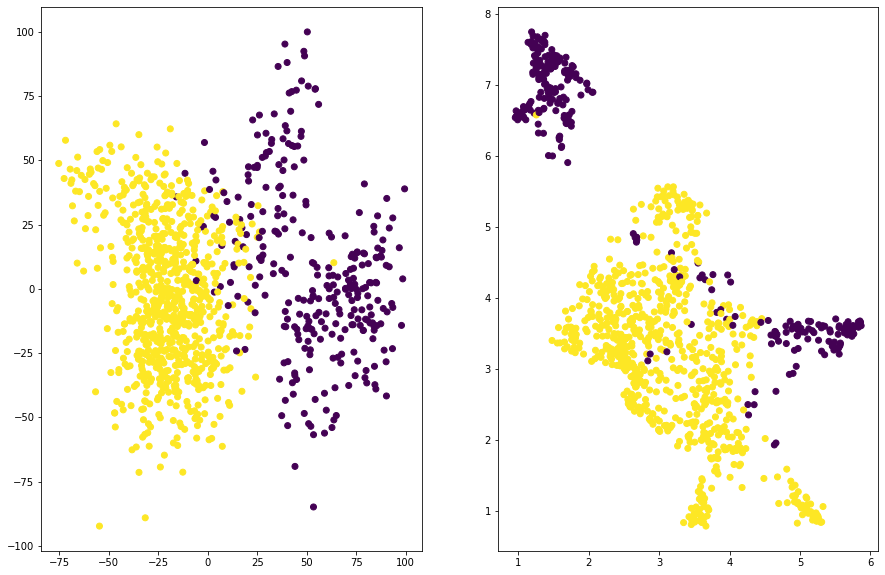

In [145]:
fig = plt.figure(figsize=(15,10))
plt.scatter(umap_components[:,0], umap_components[:,1], c=clusters['2'].values)
plt.show()

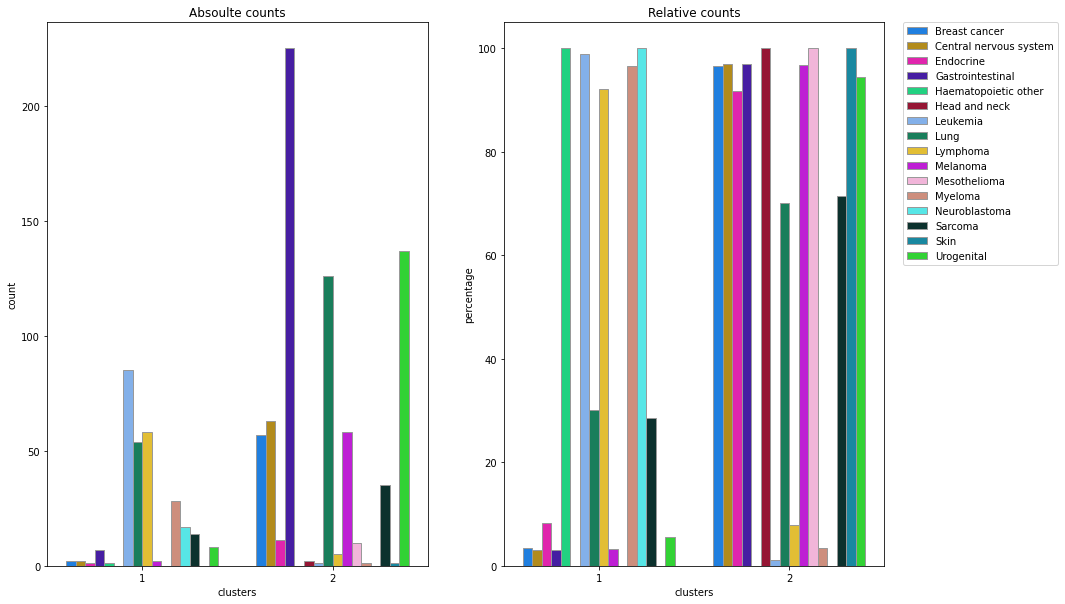

In [147]:
TCGA_IDENTIFIER_with_type['clusters'] = clusters['2'].values
make_countplot(TCGA_IDENTIFIER_with_type, 'clusters', 'TYPE2')

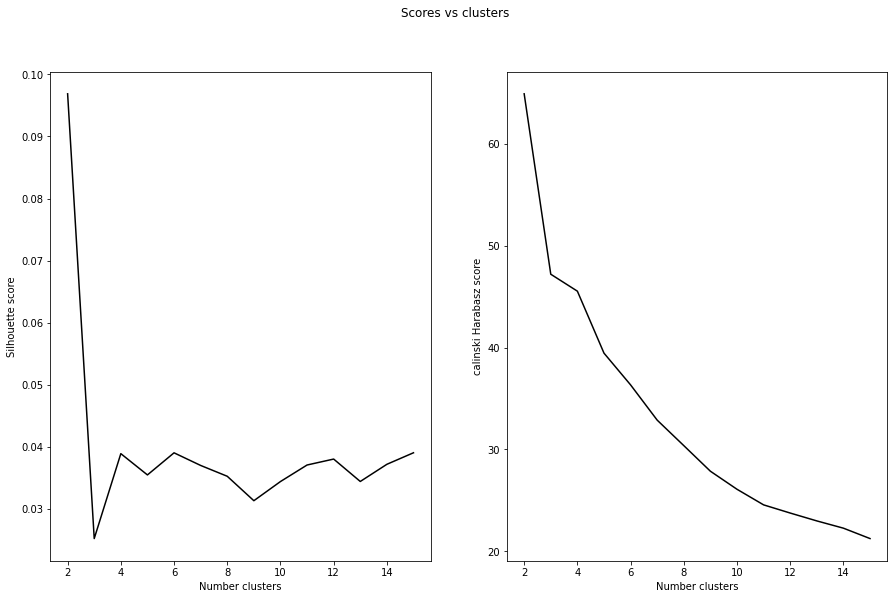

In [148]:
cluster_plot(results_grid_4['Hierarch'])

## Kmeans

In [ ]:
with open("/home/g0017139/UMCG_Thesis/Working_Code/Results/Set4/kmeans1633083088.366166.pkl", 'rb') as f:
        results_grid_4['kMeans'] = pickle.load(f)

In [ ]:
results_grid_4['kMeans'].sort_values('silhouette_score', axis=0, ascending=False).head(4)

In [ ]:
results_grid_4['kMeans'].sort_values('calinski_harabasz_score', axis=0, ascending=False).head(4)

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=2,
                         random_state=0,
                         batch_size=1024)
kmeans.fit(TCGA_norm)
fig = plt.figure(figsize=(15,10))
plt.scatter(umap_components[:,0], umap_components[:,1], c=kmeans.labels_)
plt.show()

In [ ]:
# Make the figure
TCGA_IDENTIFIER_with_type['clusters'] = kmeans.labels_
make_countplot(TCGA_IDENTIFIER_with_type, 'clusters', 'Type2')

In [ ]:
get_score(TCGA_norm, kmeans.labels_)

In [ ]:
cluster_plot(results_grid_4['kmeans'])

## DBSCAN + UMAP

In [ ]:
with open("/home/g0017139/UMCG_Thesis/Working_Code/Results/Set4/dbscan1633201635.3757062.pkl", 'rb') as f:
        results_grid_4['dbscan'] = pickle.load(f)

In [ ]:
results_grid_4['dbscan'].sort_values('silhouette_score', axis=0, ascending=False).head(4)

In [ ]:
results_grid_4['dbscan'].sort_values('calinski_harabasz_score', axis=0, ascending=False).head(4)

In [12]:
print(1)

1


In [14]:
start_time = time.time()
pipe = Pipeline([('DimReduction', 
                  umap.UMAP(
                      n_neighbors=50,
                      min_dist=1.0,
                      n_components=50,
                      random_state=1)),
                 ('Clustering', 
                 hdbscan.HDBSCAN(min_cluster_size=50,
                                min_samples=25,
                                cluster_selection_epsilon=1.0,
                                cluster_selection_method='eom'))
                ])
pipe.fit(TCGA_norm)
end_time = time.time() - start_time
#fig = plt.figure(figsize=(15,10))
# plt.scatter(umap_components[:,0], umap_components[:,1], c=pipe['Clustering'].labels_)
# plt.show()

In [19]:
end_time

280.23855543136597

In [72]:
def get_score(X, labels):
    result = {}
    try:
        if len(X) > 10_00:
                score = 0
                for _ in range(2):
                    score += silhouette_score(X, labels, metric='manhattan', sample_size=round(0.2 * len(X)))
                result['silhouette_score'] = score / 2
        else:
                result['silhouette_score'] = silhouette_score(self.X, labels, metric='manhattan')
    except Exception as e:
        print(e)

    try:
        result['calinski_harabasz_score'] = calinski_harabasz_score(X, labels)
    except:
        result['calinski_harabasz_score'] = np.nan

    try:
        result['davies_bouldin_score'] = davies_bouldin_score(X, labels)
    except:
        result['davies_bouldin_score'] = np.nan
    return result

In [52]:
for x in range(5):
    start_time1 = time.time()
    temp = get_score(TCGA_norm, pipe['Clustering'].labels_)
    end_time1 = time.time() - start_time1
    print(end_time1)
    print(temp)
    print("__________")

81.17889356613159
{'silhouette_score': 0.30444421120447585, 'calinski_harabasz_score': 285.5546755159939, 'davies_bouldin_score': 1.6049300588352495}
__________
80.78539681434631
{'silhouette_score': 0.2887184685056747, 'calinski_harabasz_score': 285.5546755159939, 'davies_bouldin_score': 1.6049300588352495}
__________
80.34397768974304
{'silhouette_score': 0.31431320222857384, 'calinski_harabasz_score': 285.5546755159939, 'davies_bouldin_score': 1.6049300588352495}
__________
80.12129020690918
{'silhouette_score': 0.29740139625480766, 'calinski_harabasz_score': 285.5546755159939, 'davies_bouldin_score': 1.6049300588352495}
__________
80.12122082710266
{'silhouette_score': 0.30127884100013547, 'calinski_harabasz_score': 285.5546755159939, 'davies_bouldin_score': 1.6049300588352495}
__________


In [ ]:
# Make the figure
TCGA_IDENTIFIER_with_type['clusters'] = pipe['Clustering'].labels_
make_countplot(TCGA_IDENTIFIER_with_type, 'clusters', 'Type2')

In [ ]:
get_score(TCGA_norm, pipe['Clustering'].labels_)

In [ ]:
cluster_plot(results_grid_4['dbscan'])

## HDDC

In [ ]:
clusters, results_grid_4['hddc'], df =  merge_Results('/home/g0017139/UMCG_Thesis/Working_Code/Results/Set4/', 'HDDC', TCGA_norm)

In [ ]:
results_grid_4['hddc'].sort_values('silhouette_score', axis=0, ascending=False).head()

In [ ]:
results_grid_4['hddc'].sort_values('calinski_harabasz_score', axis=0, ascending=False).head(4)

In [ ]:
df.head(4)

In [ ]:
TCGA_IDENTIFIER_with_type['clusters'] = clusters['2']
make_countplot(TCGA_IDENTIFIER_with_type, 'clusters', 'TYPE')

In [ ]:
get_score(TCGA_norm, clusters)

In [ ]:
cluster_plot(results_grid_4['hddc'])

In [ ]:
results_grid_4['hddc'] = pd.read_csv('/home/g0017139/UMCG_Thesis/Working_Code/Results/Set4/HDDCGrid.csv', index_col=0)
results_grid_4['hddc'] = results_grid_4['hddc'].T
clusters = pd.read_csv('Results/Set4/HDDCClusters.csv', index_col=0).values.ravel()
fig = plt.figure(figsize=(15,10))
plt.scatter(umap_components[:,0], umap_components[:,1], c=clusters)
plt.show()

In [ ]:
results_grid_4['hddc']

In [ ]:
TCGA_IDENTIFIER_with_type['clusters'] = clusters
make_countplot(TCGA_IDENTIFIER_with_type, 'clusters', 'Type2')

In [ ]:
get_score(TCGA_norm, clusters)

In [ ]:
cluster_plot(results_grid_4['hddc'])